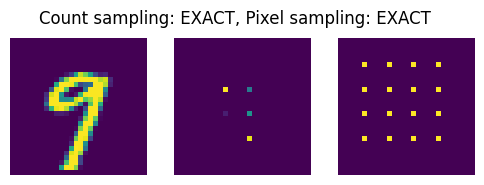

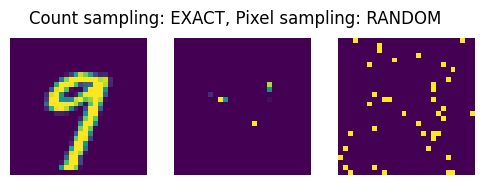

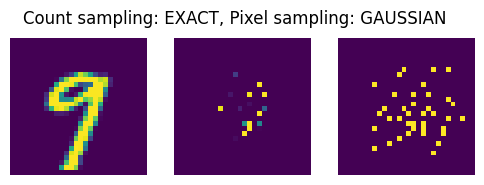

In [2]:
import torch
from config_loader import load_config, get_model_name
from datasets import load_dataset
from plotting import plot_conditioned_examples

config = load_config("VAE_16")
# Load dataset
train_loader, val_loader, test_loader, image_shape = load_dataset(config["data_params"])

plot_conditioned_examples(next(iter(train_loader))[0][0])


In [2]:
from lightning_extensions import ExtendedTrainer
from modules import VAEModule

model = VAEModule(config['model_params'], image_shape=image_shape, model_name=config['model_name'])

trainer = ExtendedTrainer(project_name="MTVAEs", **config['trainer_params'], model_name=model_name, entity=None)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/pyt ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which wi

/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory /Home/siv34/edzak2974/projects/MastersThesis/src/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name  | Type      | Params
------------------------------------
0 | model | SCVQVAE1D | 9.4 M 
------------------------------------
9.4 M     Trainable params
0         Non-trainable params
9.4 M     Total params
37.480    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 391/391 [00:07<00:00, 50.08it/s, v_num=3tgz, train_recon_loss=0.0153, train_embeddding_loss=0.00221, train_commitment_loss=0.00221, train_vq_loss=0.00276, train_loss=0.018, val_recon_loss=0.0158, val_embeddding_loss=0.00259, val_commitment_loss=0.00259, val_vq_loss=0.00323, val_loss=0.019]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 391/391 [00:07<00:00, 50.07it/s, v_num=3tgz, train_recon_loss=0.0153, train_embeddding_loss=0.00221, train_commitment_loss=0.00221, train_vq_loss=0.00276, train_loss=0.018, val_recon_loss=0.0158, val_embeddding_loss=0.00259, val_commitment_loss=0.00259, val_vq_loss=0.00323, val_loss=0.019]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_commitment_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_embeddding_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_recon_loss,█▄▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▂▂▁▂▂▁▁▁▂▁▂▁
train_vq_loss,█▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_commitment_loss,█▆▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_embeddding_loss,█▆▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_recon_loss,█▇▆▅▄▃▂▂▂▃▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▂▂▁▁▂▁▂▂▂▂▂▁▂▂▂


VAE(16)?dataset=CIFAR10&batch_size=128&max_epochs=60


/Home/siv34/edzak2974/.conda/envs/pytorch2.1/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


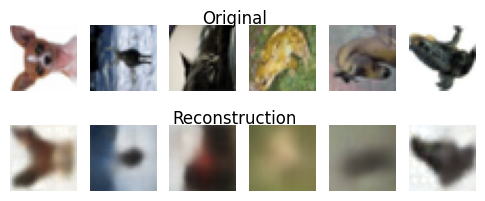

Model is None or latent dim is not 2 or model has no decoder


In [3]:
from modules import VAEModule
print(model_name)
model = VAEModule.load_model_checkpoint(model_name = model_name)
model.eval()
from plotting import plot_stage_one_results
# plot some samples and their reconstruction

plot_stage_one_results(model, test_loader)